In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [12]:
import sys
import os
sys.path.append("../../../")

import pickle
import geopandas as gpd
from pathlib import Path
import getpass
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

from povertymapping.rollout_grids import get_region_filtered_bingtile_grids 
from povertymapping import settings, nightlights
from povertymapping.iso3 import get_iso3_code
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.feature_engineering import generate_features, categorize_wealth_index
from povertymapping.osm import get_osm_extent 
from povertymapping.ookla import OoklaDataManager
import gc
from loguru import logger
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
import shap

# Indonesia Model Rollout Part 3 (Feature Engineering and Model Prediction on Rollout Grids)

This notebook runs the final model to create relative wealth estimations over populated areas within the given country. The model predictions will have a spatial resolution of 2.4km.

The `predicted relative wealth` value is calculated as the number of standard deviations away from the overall country-mean DHS wealth index, and gives us the relative wealth level of that area compared to the rest of the country. For example, an area with `y=0` is at the average wealth value, while an area with `y=1` means that it's richer than the average area by 1 standard deviation.

The predicted relative wealth value is later binned into 5 wealth categories A-E based on a split quintile approach. 

## Set up Data Access
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [3]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)


Username? jcnacpil@thinkingmachin.es
Password? ········


2023-03-23 17:28:10.009 | INFO     | povertymapping.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-03-23 17:28:10.011 | INFO     | povertymapping.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Set country-specific parameters
For Indonesia, we need to process the OSM data per subregion, listed in `country_subareas_osm`

In [5]:
REGION = "indonesia"
country_subareas_osm = country_subareas_osm = ["maluku","sulawesi", "sumatra", "java", "kalimantan",  "nusa-tenggara", "papua"]
# country_subareas_osm = country_subareas_osm = ["java"]
ookla_year = 2019
nightlights_year = 2019
country_code = get_iso3_code(REGION, code='alpha-2').lower()
rollout_date = '-'.join(os.getcwd().split('/')[-2].split('-')[:3])
rollout_grids_path = Path(f'./{rollout_date}-{country_code}-rollout-grids.geojson')
rollout_grids_path

Path('2023-02-21-id-rollout-grids.geojson')

## Set Model Parameters

In [34]:
# Model to use for prediction
MODEL_SAVE_PATH = Path(f'../{rollout_date}-cross-country-model-minmax.pkl')

## Load Country Rollout AOI

The rollout area of interest is split into 2.4km grid tiles (zoom level 14), matching the areas used during model training. The grids are also filtered to only include populated areas based on Meta's High Resolution Settlement Layer (HRSL) data.

Refer to the previous notebook `2_id_generate_grids.ipynb` for documentation on generating this grid.

In [7]:
aoi = gpd.read_file(rollout_grids_path)
aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 161230 entries, 0 to 161229
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   quadkey         161230 non-null  object  
 1   shapeName       161230 non-null  object  
 2   shapeISO        161230 non-null  object  
 3   shapeID         161230 non-null  object  
 4   shapeGroup      161230 non-null  object  
 5   shapeType       161230 non-null  object  
 6   quadkey_level8  161230 non-null  object  
 7   pop_count       161230 non-null  float64 
 8   geometry        161230 non-null  geometry
dtypes: float64(1), geometry(1), object(7)
memory usage: 11.1+ MB


## Generate Features For Rollout AOI

### Retrieve base data 
Unlike other rollouts, we will first get the data per subarea, combine them, then scale them afterwards to get the final features set

In [8]:
%%time
subarea_data_list = []
for subarea_osm in country_subareas_osm:
    subarea_extent = get_osm_extent(subarea_osm)
    aoi_in_subarea = gpd.sjoin(
        aoi, 
        subarea_extent, 
        how='inner', 
        predicate='intersects'
    ).drop(columns=['index_right']).reset_index(drop=True)
    logger.info(f"Processing aoi grids in osm_region: {subarea_osm} (n = {len(aoi_in_subarea)})")
    
    aoi_in_subarea = generate_features(
        aoi_in_subarea,
        subarea_osm,
        ookla_year,
        nightlights_year,
        scale = False,
        features_only = False,
        use_aoi_quadkey = True,
        aoi_quadkey_col = "quadkey"
    )
    subarea_data_list.append(aoi_in_subarea)

# Combine all country data into a single dataframe
aoi_data = gpd.GeoDataFrame(pd.concat(subarea_data_list,ignore_index=True), crs=subarea_data_list[0].crs)

# There may be duplicates for rows that are in between two subareas. 
# For now we will just keep the first occurence
aoi_data = aoi_data.drop_duplicates("quadkey")

2023-03-23 17:37:24.889 | INFO     | __main__:<module>:10 - Processing aoi grids in osm_region: maluku (n = 5382)
2023-03-23 17:37:24.891 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for maluku at /home/jc_tm/.geowrangler/osm/maluku? True
2023-03-23 17:37:24.892 | DEBUG    | povertymapping.osm:load_pois:161 - OSM POIs for maluku being loaded from /home/jc_tm/.geowrangler/osm/maluku/gis_osm_pois_free_1.shp
2023-03-23 17:37:26.697 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for maluku at /home/jc_tm/.geowrangler/osm/maluku? True
2023-03-23 17:37:26.697 | DEBUG    | povertymapping.osm:load_roads:180 - OSM Roads for maluku being loaded from /home/jc_tm/.geowrangler/osm/maluku/gis_osm_roads_free_1.shp
2023-03-23 17:37:28.556 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2023-03-23 17:37:28.558 | INFO     | povertymapping.ookla:load_type_year_data:94 

CPU times: user 14min 7s, sys: 1min 52s, total: 15min 59s
Wall time: 16min 14s


In [9]:
aoi_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 161230 entries, 0 to 161238
Data columns (total 71 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   quadkey                            161230 non-null  object  
 1   shapeName                          161230 non-null  object  
 2   shapeISO                           161230 non-null  object  
 3   shapeID                            161230 non-null  object  
 4   shapeGroup                         161230 non-null  object  
 5   shapeType                          161230 non-null  object  
 6   quadkey_level8                     161230 non-null  object  
 7   pop_count                          161230 non-null  float64 
 8   geometry                           161230 non-null  geometry
 9   osm_region                         161230 non-null  object  
 10  poi_count                          161230 non-null  float64 
 11  atm_count         

In [10]:
%%time
# Uncomment this cell and run to save a local copy of the raw features
aoi_data.to_file(f'{rollout_date}-{country_code}-rollout-features.geojson', driver='GeoJSON', index=False)

CPU times: user 5min 11s, sys: 7.53 s, total: 5min 19s
Wall time: 5min 19s


### Scale and clean features

In [11]:
# Get list of raw features generated 
feature_cols = [x for x in aoi_data.columns if x not in list(aoi.columns) + ["osm_region"]]

In [52]:
scaler = MinMaxScaler()
q = 100 # express in terms of 0-100
q_decimal = q / 100

In [53]:
%%time
features = aoi_data[feature_cols].copy()
for col in feature_cols:
    max_val = features[[col]].quantile(q_decimal)
    features[col + "_scaled"] = scaler.fit_transform(features[[col]].clip(upper=max_val, axis=1))

# Keep only scaled columns
features = features[[col for col in features.columns if '_scaled' in col]]

CPU times: user 5.15 s, sys: 9.04 ms, total: 5.16 s
Wall time: 5.14 s


In [54]:
# Uncomment this cell and run to save a local copy of the scaled features
aoi_features = pd.concat([aoi_data, features], axis=1)
aoi_features = aoi_features[[col for col in aoi_features.columns if col not in feature_cols]] # remove raw feature columns
aoi_features = gpd.GeoDataFrame(aoi_features, crs=aoi.crs)
aoi_features.to_file(f'{rollout_date}-{country_code}-rollout-features-scaled-minmax-q{q}.geojson', driver='GeoJSON', index=False)

### Make copy of aoi for rollout

In [55]:
rollout_aoi = aoi_data.copy()
rollout_aoi = rollout_aoi[[col for col in rollout_aoi.columns if col not in feature_cols]] # remove raw feature columns
rollout_aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 161230 entries, 0 to 161238
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   quadkey         161230 non-null  object  
 1   shapeName       161230 non-null  object  
 2   shapeISO        161230 non-null  object  
 3   shapeID         161230 non-null  object  
 4   shapeGroup      161230 non-null  object  
 5   shapeType       161230 non-null  object  
 6   quadkey_level8  161230 non-null  object  
 7   pop_count       161230 non-null  float64 
 8   geometry        161230 non-null  geometry
 9   osm_region      161230 non-null  object  
dtypes: float64(1), geometry(1), object(8)
memory usage: 17.6+ MB


## Inspect the generated features

In [56]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161230 entries, 0 to 161238
Data columns (total 61 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   poi_count_scaled                          161230 non-null  float64
 1   atm_count_scaled                          161230 non-null  float64
 2   atm_nearest_scaled                        161230 non-null  float64
 3   bank_count_scaled                         161230 non-null  float64
 4   bank_nearest_scaled                       161230 non-null  float64
 5   bus_station_count_scaled                  161230 non-null  float64
 6   bus_station_nearest_scaled                161230 non-null  float64
 7   cafe_count_scaled                         161230 non-null  float64
 8   cafe_nearest_scaled                       161230 non-null  float64
 9   charging_station_count_scaled             161230 non-null  float64
 10  charging_station_nea

## Run Model on AOI

### Load Model

In [57]:
with open(MODEL_SAVE_PATH,'rb') as f:
    model = pickle.load(f)

### Make Predictions

In [58]:
rollout_aoi['Predicted Relative Wealth Index'] = model.predict(features.values)

### Inspect predicted wealth index and output dataframe

array([[<AxesSubplot: title={'center': 'Predicted Relative Wealth Index'}>]],
      dtype=object)

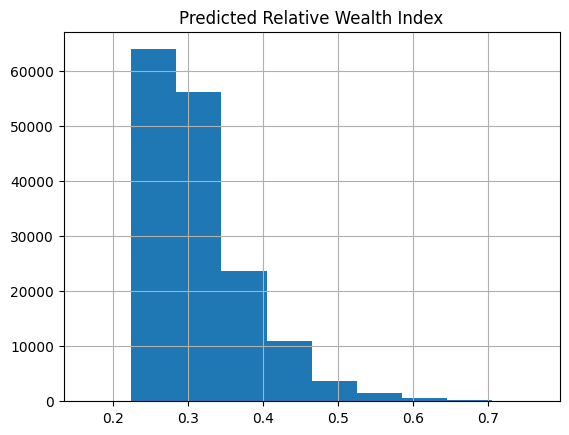

In [59]:
rollout_aoi[['Predicted Relative Wealth Index']].hist()

The Predicted Relative Wealth Index map should look like this.

Note: For Indonesia, we do not plot a folium interactive map as the map becomes too slow when loading >100,000 grids.

<Figure size 640x480 with 0 Axes>

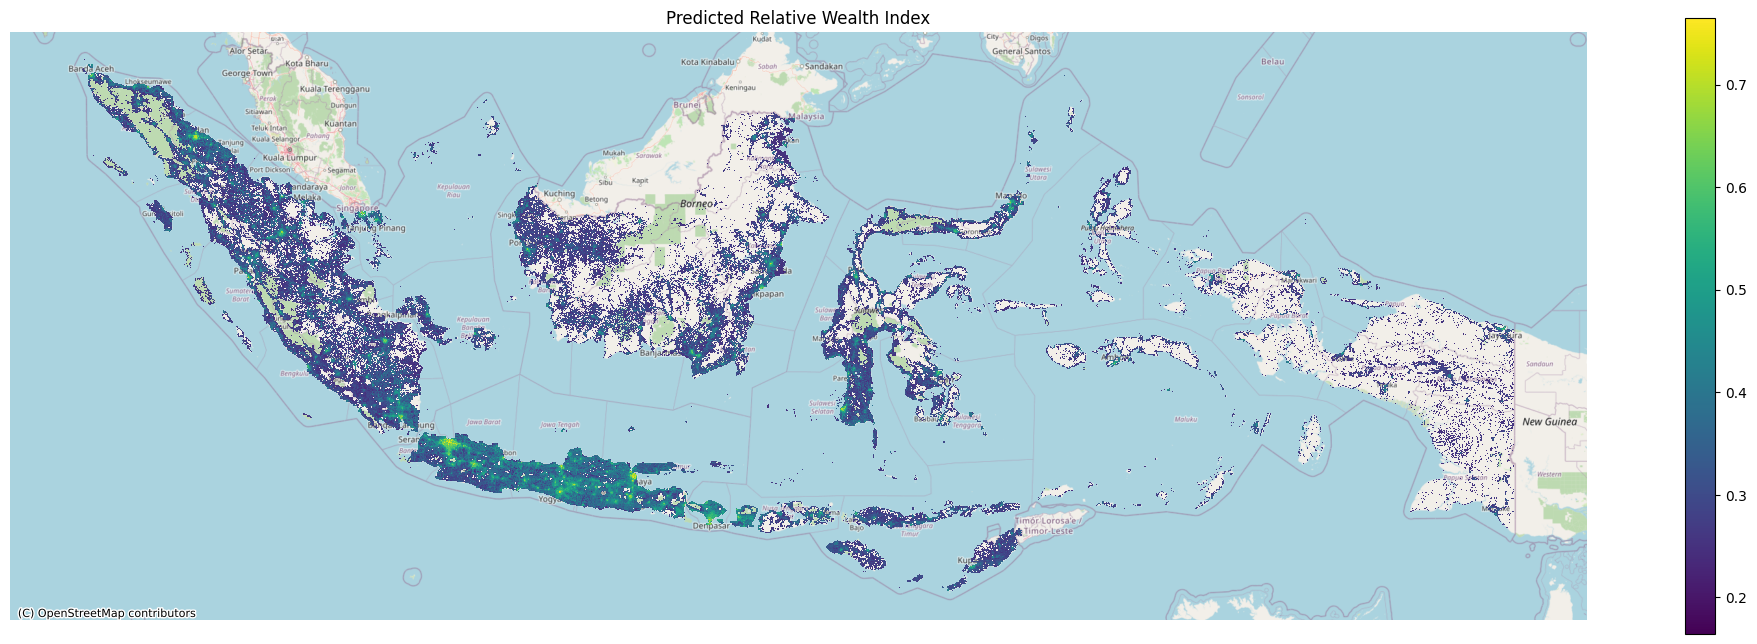

In [60]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot("Predicted Relative Wealth Index", figsize=(20, 8), cmap="viridis", legend=True, legend_kwds={'shrink': 0.8})
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Relative Wealth Index")
plt.tight_layout()
plt.savefig(f'{rollout_date}-{country_code}-predicted-wealth-index.png')
plt.show()

In [61]:
rollout_aoi.head()

,quadkey,shapeName,shapeISO,shapeID,shapeGroup,shapeType,quadkey_level8,pop_count,geometry,osm_region,Predicted Relative Wealth Index
0,31011002030001,Banggai Laut,None,IDN-ADM2-3_0_0-B22,IDN,ADM2,31011002,231.423157,"POLYGON ((124.12354 -1.77950, 124.12354 -1.757...",maluku,0.261664
1,31011002030010,Banggai Laut,None,IDN-ADM2-3_0_0-B22,IDN,ADM2,31011002,611.618347,"POLYGON ((124.14551 -1.77950, 124.14551 -1.757...",maluku,0.278987
2,31011002031000,Pulau Taliabu,None,IDN-ADM2-3_0_0-B416,IDN,ADM2,31011002,16.530226,"POLYGON ((124.27734 -1.77950, 124.27734 -1.757...",maluku,0.249601
3,31011002013223,Pulau Taliabu,None,IDN-ADM2-3_0_0-B416,IDN,ADM2,31011002,24.795338,"POLYGON ((124.29932 -1.75754, 124.29932 -1.735...",maluku,0.249601
4,31011002031001,Pulau Taliabu,None,IDN-ADM2-3_0_0-B416,IDN,ADM2,31011002,8.265113,"POLYGON ((124.29932 -1.77950, 124.29932 -1.757...",maluku,0.249601


In [62]:
rollout_aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 161230 entries, 0 to 161238
Data columns (total 11 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   quadkey                          161230 non-null  object  
 1   shapeName                        161230 non-null  object  
 2   shapeISO                         161230 non-null  object  
 3   shapeID                          161230 non-null  object  
 4   shapeGroup                       161230 non-null  object  
 5   shapeType                        161230 non-null  object  
 6   quadkey_level8                   161230 non-null  object  
 7   pop_count                        161230 non-null  float64 
 8   geometry                         161230 non-null  geometry
 9   osm_region                       161230 non-null  object  
 10  Predicted Relative Wealth Index  161230 non-null  float64 
dtypes: float64(2), geometry(1), object(8)
memory

## Binning predictions into wealth categories

Afterwards, we label the predicted relative wealth by binning them into 5 categories based on quintiles

|Category |Description| 
|---|-----------------| 
| A | high income | 
| B | mid-high income | 
| C | middle income | 
| D | mid-low income | 
| E | low income |



### Calculate equal-quintile wealth category

In [63]:
rollout_aoi["Predicted Wealth Category (quintile)"] = categorize_wealth_index(
    rollout_aoi["Predicted Relative Wealth Index"], split_quantile=False
).astype(str)


### Calculate split-quintile wealth category

## Save output

In [64]:
%%time
rollout_aoi.to_file(f'{rollout_date}-{country_code}-rollout-output.geojson', driver='GeoJSON', index=False)

CPU times: user 34.8 s, sys: 368 ms, total: 35.2 s
Wall time: 35.2 s


## Shap analysis for kalimantan and java

In [65]:
import shap
explainer = shap.TreeExplainer(model)

In [66]:
jakarta_mask = rollout_aoi['shapeName'].str.contains('Jakarta')
len(jakarta_mask)

161230

In [67]:
len(features)

161230

In [68]:
jakarta_features = features[jakarta_mask]
jakarta_features

,poi_count_scaled,atm_count_scaled,atm_nearest_scaled,bank_count_scaled,bank_nearest_scaled,bus_station_count_scaled,bus_station_nearest_scaled,cafe_count_scaled,cafe_nearest_scaled,charging_station_count_scaled,...,mobile_2019_mean_avg_d_kbps_mean_scaled,mobile_2019_mean_avg_u_kbps_mean_scaled,mobile_2019_mean_avg_lat_ms_mean_scaled,mobile_2019_mean_num_tests_mean_scaled,mobile_2019_mean_num_devices_mean_scaled,avg_rad_min_scaled,avg_rad_max_scaled,avg_rad_mean_scaled,avg_rad_std_scaled,avg_rad_median_scaled
79715,0.007503,0.000000,0.094781,0.0000,0.087530,0.0,0.0,0.024691,0.000000,0.0,...,0.043397,0.047668,0.025699,0.009674,0.010235,0.100401,0.025330,0.062293,0.024497,0.060163
80255,0.019293,0.000000,0.240487,0.0625,0.000000,0.0,0.0,0.000000,0.084249,0.0,...,0.060790,0.112907,0.010178,0.102785,0.082946,0.502444,0.022002,0.154149,0.007996,0.159829
80261,0.018221,0.000000,0.118737,0.0000,0.010263,0.0,0.0,0.000000,0.037225,0.0,...,0.049158,0.110008,0.010764,0.177668,0.145926,0.505677,0.021190,0.158853,0.007141,0.168967
80266,0.068596,0.000000,0.001821,0.1750,0.000000,0.0,0.0,0.061728,0.000000,0.0,...,0.060510,0.122356,0.009440,0.240224,0.261774,0.546303,0.032059,0.201255,0.020015,0.195273
80267,0.042872,0.037736,0.000000,0.1000,0.000000,0.0,0.0,0.000000,0.012776,0.0,...,0.057750,0.115703,0.009711,0.135054,0.123635,0.510127,0.018669,0.148435,0.004104,0.155647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81269,0.041801,0.000000,0.043954,0.2125,0.000000,0.0,0.0,0.000000,0.220402,0.0,...,0.057338,0.123062,0.009239,0.218789,0.189194,0.536215,0.023495,0.181461,0.009421,0.198974
81270,0.060021,0.037736,0.000000,0.2500,0.000000,0.0,0.0,0.000000,0.022894,0.0,...,0.068621,0.141032,0.007907,0.146485,0.128438,0.549026,0.023477,0.175549,0.007547,0.184401
81275,0.018221,0.000000,0.223219,0.0250,0.000000,0.0,0.0,0.000000,0.400871,0.0,...,0.056002,0.117667,0.008862,0.127215,0.094874,0.572922,0.023753,0.172972,0.007897,0.184520
81276,0.013934,0.000000,0.137722,0.0125,0.000000,0.0,0.0,0.000000,0.221772,0.0,...,0.053302,0.119549,0.009165,0.152878,0.137486,0.522801,0.026694,0.170201,0.014204,0.171580


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


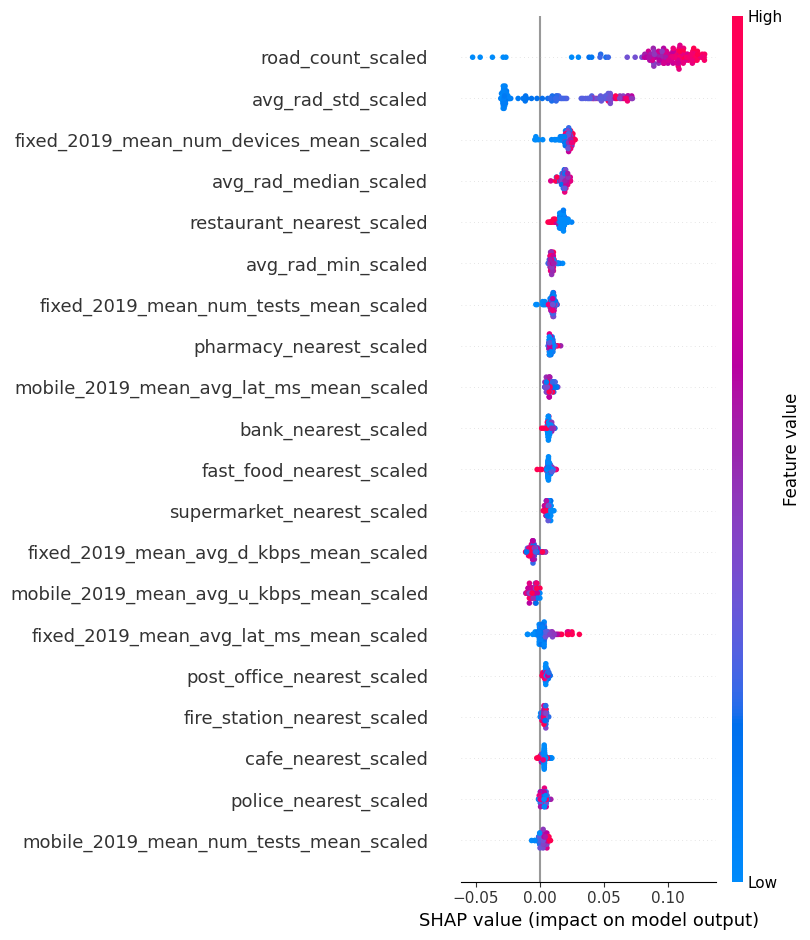

In [69]:
shap_values = explainer.shap_values(jakarta_features)
shap.summary_plot(shap_values, jakarta_features.values, feature_names=jakarta_features.columns)

In [70]:
kalimantan_mask = aoi_data['osm_region'] == 'kalimantan'
kalimantan_features = features[kalimantan_mask]

In [ ]:
shap_values = explainer.shap_values(kalimantan_features)
shap.summary_plot(shap_values, kalimantan_features.values, feature_names=kalimantan_features.columns)